## Generate Figure 5, for the sensitivity analysis manuscript
Here we generate the parameter recovery figure for the sensitivity analysis manuscript. 

This figure consists of three main components: a heatmap displaying the ability to recover each given parameter and light schedule pair, three example figures of recovery error for given parameter and light schedule pairs, and a bar plot with an overall summary of the recovery error for each parameter. We generate results and plots for each of these figure components in the sections below. 

In [1]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, jacfwd, jacrev
import jax.numpy as jnp

# import the needed modules 
from hessian_normalized import HessianCircadian
from hessian_normalized import ParameterRecovery

from lightschedules import RegularLight
from lightschedules import ShiftWorkLight
from lightschedules import ShiftWorkerThreeTwelves
from lightschedules import SocialJetLag
from lightschedules import SlamShift

sens=HessianCircadian()
recov = ParameterRecovery()
params = sens.get_parameters_array()

figure_save = 'off'

# define the light schedules 
ndays = 7
intensity = 979
dt = 0.1
ts=np.arange(0, 24*ndays, dt)
lights_rl = jnp.array([RegularLight(t, Intensity = intensity) for t in ts ]) # define the light schedules 
lights_sw = jnp.array([ShiftWorkLight(t,Intensity = intensity) for t in ts ])
lights_sw312 = jnp.array([ShiftWorkerThreeTwelves(t,Intensity = intensity) for t in ts ])
lights_sjl = jnp.array([SocialJetLag(t,Intensity = intensity) for t in ts ])
lights_ss = jnp.array([SlamShift(t,Intensity = intensity) for t in ts ])
lights_dark = jnp.zeros([len(ts),])

Read in the initial conditions and parameter distribution results from MCMC run of the model. 

In [2]:
# get stored initial conditions, generated in ics_generate.ipynb
%store -r ics_rl
%store -r ics_sw
%store -r ics_sw312
%store -r ics_sjl
%store -r ics_ss
%store -r ics_dark

# read in the mcmc results 
import pandas as pd

# read in the data 
mcmc_runs = pd.read_csv('mcmc_new_run.tsv', header = None, delimiter = '\t').to_numpy()
# list: tau, K, gamma, A1, A2, BetaL1, BetaL2, sigma, p, I0, alpha0, Beta1, ent_angle, cost, dd_period
mcmc_param_list = ["tau", "K", "gamma","A1", "A2", "BetaL1", "BetaL2", "sigma", "p_fixed", "I0_fixed", "alpha_0_fixed", "Beta1", "ent_angle", "cost", "dd_period"]
model_param_list = ["tau", "K", "gamma", "Beta1", "A1", "A2", "BetaL1", "BetaL2", "sigma", "G", "alpha_0", "delta", "p", "I0"]

Generate the model states with default parameters and noisy light. 

We add in noise from a normal distribution with mean $\mu$ and standard deviation $\sigma$: see hessian_normalized.py for more details. Using this adjusted light schedule, we compute the resulting model states for each of the six individual light schedules. 

In [3]:
# parameters to define noisy light 
mu = 0
sigma = 100

states_rl_noisy_light = recov.noisy_light(mu, sigma, lights_rl, ts)
states_sw_noisy_light = recov.noisy_light(mu, sigma, lights_sw, ts)
states_sw312_noisy_light = recov.noisy_light(mu, sigma, lights_sw312, ts)
states_ss_noisy_light = recov.noisy_light(mu, sigma, lights_ss, ts)
states_sjl_noisy_light = recov.noisy_light(mu, sigma, lights_sjl, ts)
states_dark_noisy_light = recov.noisy_light(mu, sigma, lights_dark, ts)

Generate the model states with perturbed parameters and non-noisy light. 

For each parameter value, we iterate through num_iter values of the parameter. The parameter values that we chose are based on percentiles of the (shifted) distribution from the MCMC runs, when available. If not we take percentages of the default parameter value. 

While running this analysis, we determine the model states given the perturbed parameter. We then store the norm difference between the model states with the noisy light schedule + default parameter and the model states with the non-noisy light schedule + perturbed parameters.

In [4]:
num_iter = 20

# initialize the results 
state_diff_rl = np.zeros([num_iter, len(params)])
state_diff_sw = np.zeros([num_iter, len(params)])
state_diff_sw312 = np.zeros([num_iter, len(params)])
state_diff_ss = np.zeros([num_iter, len(params)])
state_diff_sjl = np.zeros([num_iter, len(params)])
state_diff_dark = np.zeros([num_iter, len(params)])

# loop through the parameters and iterations 
for j in range(len(params)):
    
    print(j)
    
    for m in range(num_iter):
        
        param_name = model_param_list[j]
        rand_percent_vec = 0.96+(m-1)*0.005 #0.96+m*0.01
        params_perturb = params
        
        if param_name in mcmc_param_list: 
            
            index = mcmc_param_list.index(param_name)
            med_val = np.quantile(mcmc_runs[:,index],0.50) 
            def_val = params[j] 
            shift = med_val - def_val
            params_perturb = params_perturb.at[j].set(np.quantile(mcmc_runs[:,index],(m+1)/num_iter) - shift) # simplify
            
        else:
            
            params_perturb = params_perturb.at[j].set(params[j]*rand_percent_vec)
        
        states_rl_params = recov.perturbed_params(ics_rl, params_perturb, lights_rl, ts)
        states_sw_params = recov.perturbed_params(ics_sw, params_perturb, lights_sw, ts)
        states_sw312_params = recov.perturbed_params(ics_sw312, params_perturb, lights_sw312, ts)
        states_ss_params = recov.perturbed_params(ics_ss, params_perturb, lights_ss, ts)
        states_sjl_params = recov.perturbed_params(ics_sjl, params_perturb, lights_sjl, ts)
        states_dark_params = recov.perturbed_params(ics_dark, params_perturb, lights_dark, ts)
        state_diff_rl[m,j] = recov.loss_recovery(states_rl_noisy_light, states_rl_params,ts)
        state_diff_sw[m,j] = recov.loss_recovery(states_sw_noisy_light, states_sw_params,ts)
        state_diff_sw312[m,j] = recov.loss_recovery(states_sw312_noisy_light, states_sw312_params,ts)
        state_diff_ss[m,j] = recov.loss_recovery(states_ss_noisy_light, states_ss_params,ts)
        state_diff_sjl[m,j] = recov.loss_recovery(states_sjl_noisy_light, states_sjl_params,ts)
        state_diff_dark[m,j] = recov.loss_recovery(states_dark_noisy_light, states_dark_params,ts)


0
1
2
3
4
5
6
7
8
9
10
11
12
13


## Generate heatmap figure 
Next we generate a figure where we plot the difference in index between that of the minimum recovery error and what should be the minimum recovery error, for each parameter and light schedule combination. Note that index 0 signifies perfect recovery. 

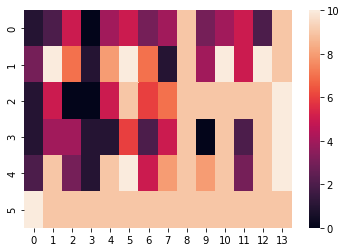

In [10]:
import seaborn as sns 
num_schedules = 6

# generate the heatmap
heatmap_v1 = np.zeros([num_schedules,len(params)])
heatmap_v1[0,:] = np.nanargmin(state_diff_rl, axis = 0) # check the axis
heatmap_v1[1,:] = np.nanargmin(state_diff_sw, axis = 0)
heatmap_v1[2,:] = np.nanargmin(state_diff_sw312, axis = 0)
heatmap_v1[3,:] = np.nanargmin(state_diff_sjl, axis = 0)
heatmap_v1[4,:] = np.nanargmin(state_diff_ss, axis = 0)
heatmap_v1[5,:] = np.nanargmin(state_diff_dark, axis = 0)
heatmap_v1 = abs(heatmap_v1 - 9)

sns.heatmap(heatmap_v1)
if figure_save == 'on':
    plt.savefig('figures_8_29/param_recov_hm1_v4.svg')

## Generate example recovery error plots 
Here we plot three example plots of recovery errors for given light schedule and parameter combinations. 

Specifically, we plot the recovery error for $\tau$ under a real light schedule, for $K$ under the shift work light schedule, and for $\alpha_0$ under the shift work three twelve's light schedule. Change the state_diff_ value to change the light schedule, and change the indices to change the parameters. 

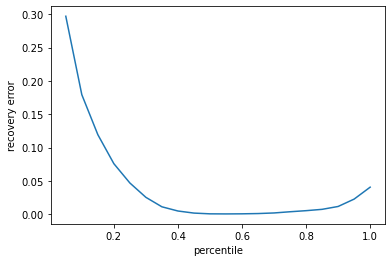

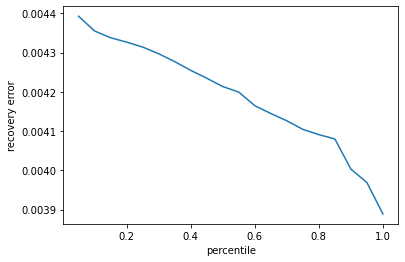

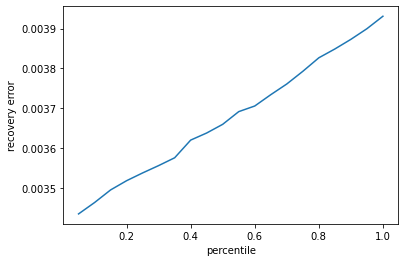

In [18]:
# choose the three parameters to examine 
index1 = 0 # tau
index2 = 1 # K
index3 = 10 # alpha_0

# generate the example figures 
x_vals = np.linspace(1/num_iter, 1, num_iter)
plt.plot(x_vals,state_diff_rl[:,index1])
plt.xlabel('percentile')
plt.ylabel('recovery error')
if figure_save == 'on':
    plt.savefig('figures_8_29/rl_tau_recov_err_v4.svg')
plt.show()

plt.plot(x_vals,state_diff_sw[:,index2])
plt.xlabel('percentile')
plt.ylabel('recovery error')
if figure_save == 'on':
    plt.savefig('figures_8_29/sw_k_recov_err_v4.svg')
plt.show()

plt.plot(x_vals,state_diff_sw312[:,index3])
plt.xlabel('percentile')
plt.ylabel('recovery error')
if figure_save == 'on':
    plt.savefig('figures_8_29/sw_alph_recov_err_v4.svg')
plt.show()

Finally, we generate the average recovery error for each parameter. Here we average across light schedules and parameter perturbations. 

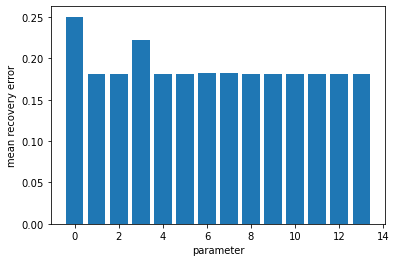

In [34]:
# generate the average recovery error for each parameter 
combined_state_diff = np.concatenate((state_diff_rl, state_diff_sw, state_diff_sw312, state_diff_sjl, state_diff_ss, state_diff_dark))
plt.bar(range(len(params)), np.mean(combined_state_diff, axis = 0))
plt.xlabel('parameter')
plt.ylabel('mean recovery error')
if figure_save == 'on':
    plt.savefig('figures_8_29/mean_recov_err_param_v4.svg')
plt.show()